# Imports

In [1]:
# Python standard library
import sys
import os

# Scientific computing
import cv2
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline

# Program specific
PORE_STATS_BASE_DIRECTORY = '/home/prestonh/Desktop/Research/pore_stats'

sys.path.append(PORE_STATS_BASE_DIRECTORY + '/pore_stats/rp/')
import resistive_pulse as rp
import rp_file

sys.path.append(PORE_STATS_BASE_DIRECTORY + '/pore_stats/oi/')
import optical_imaging as oi
import oi_file



# Jupyter
from IPython.display import HTML

# Load data

In [2]:
# Define file path
date = '/3-9-2017'
particle = '/10um_ps'
chip = '/20-50-20_1'
file_index = '0'


base_directory = '/home/prestonh/Desktop/Research/cancer_cells/data/'+date+particle+chip

### Open RP

In [3]:
rp_fps = 250000.


# RP data files
rp_data_file_directory = base_directory + '/rp/bts/'
rp_data_file_name = 'test_rp_'+file_index+'.bts'
rp_data_file_path = rp_data_file_directory + rp_data_file_name

rp_data = rp_file.get_data(rp_data_file_path)



# RP event files
rp_events_file_directory = base_directory + '/rp/events/'
rp_events_file_name = 'test_rp_' + file_index + '_events_sync.json'
rp_events_file_path = rp_events_file_directory + rp_events_file_name

rp_events = rp_file.open_event_file_json(rp_events_file_path)

### Open IM

In [4]:
oi_res_x = 512
oi_res_y = 288
oi_fps = 50000.
oi_exp = 2

# OI data files
oi_vid_file_directory = base_directory + '/oi/bin/'
oi_vid_file_name = 'test_camera_' + file_index
oi_vid_file_path = oi_vid_file_directory + oi_vid_file_name

oi_vid = oi_file.Video(oi_vid_file_path, oi_res_x, oi_res_y, oi_fps, oi_exp)


# OI event files
oi_events_file_directory = base_directory + '/oi/events/'
oi_events_file_name = 'test_camera_' + file_index + '_events_sync.json'
oi_events_file_path = oi_events_file_directory + oi_events_file_name

oi_events = oi_file.open_event_file_json(oi_events_file_path)

/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pixels != None:


##### Set template frame and define stage

[ 0.02226169  0.99975218]


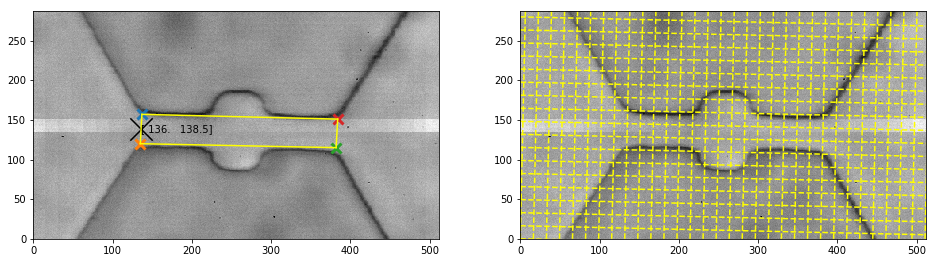

In [5]:
reload(oi)
template_index = 0
template_frame = oi_vid.get_frame(template_index)
c0 = [137,157]
c1 = [135,120]
c2 = [382,115]
c3 = [384,151]
oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

# Ellipse fits

In [6]:
def plot_frame(frame, show = True):
    plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
    
    if show:
        plt.show()
    
def plot_processed_over_raw(processed_frame, frame, show = True):
    green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
    green_processed_frame[:,:,1] = processed_frame

    plt.imshow(frame, cmap = 'gray', origin = 'lower', alpha = 1, interpolation = 'none')
    plt.imshow(green_processed_frame, cmap = 'gray', origin = 'lower', alpha = 0.15, interpolation = 'none')

    if show:
        plt.show()
    
def plot_frame_hist(frame, show = True):
    plt.hist(frame.flatten(), facecolor = 'k', bins = 100)
    
    if show:
        plt.show()
    
def plot_all(processed_frame, frame):
    fig, axes = plt.subplots(1,3,figsize = (12,3))
    
    # Plot 1
    plt.sca(axes[0])
    plot_frame(processed_frame, show = False)
    
    
    # Plot 2
    plt.sca(axes[1])
    plot_processed_over_raw(processed_frame, frame, show = False)
    
    # Plot 3
    plt.sca(axes[2])
    plot_frame_hist(processed_frame, show = False)
    
    plt.show()

In [45]:
def crop_frame(frame, px, py, crop_distance):    
    x0 = int(px - crop_distance)
    x1 = int(px + crop_distance)
    y0 = int(py - crop_distance)
    y1 = int(py + crop_distance)
    cropped_frame = np.copy(frame)[y0:y1, x0:x1]
    
    return cropped_frame
    

preprocessing_steps = []



        


def preprocess_fit_ellipse(raw_frame, raw_template_frame, detection, debug = 'none'):

    
    
    
    # Refresh list
    del preprocessing_steps[:]

    

    
    #################################
    # Copy
    #################################
    
    
    
    preprocessing_steps.append(['copy'])

    processed_template_frame = np.copy(raw_template_frame)
    processed_frame = np.copy(raw_frame)
    

    if debug == 'all':
        print 'copy'
        plot_all(processed_frame, raw_frame)
        
        
    #################################
    # Crop
    #################################
    
    crop_distance = 30
    
    preprocessing_steps.append(['crop'] + [crop_distance])

    processed_frame = crop_frame(processed_frame, detection._px, detection._py, crop_distance)
    processed_template_frame = crop_frame(processed_template_frame, detection._px, detection._py, crop_distance)
    frame = np.copy(processed_frame)

    if debug == 'all':
        print 'crop'
        plot_all(processed_frame, frame)
        
        




    #################################
    # Blur
    #################################


    blur_kernel = (5,5)    # 19
    preprocessing_steps.append(['gaussian blur', blur_kernel])

    
    processed_frame = cv2.GaussianBlur(processed_frame, blur_kernel, 0)
    processed_template_frame = cv2.GaussianBlur(processed_template_frame, blur_kernel, 0)
    


    if debug == 'all':
        print 'gaussian blur', blur_kernel
        plot_all(processed_frame, frame)
    
    

        
        

        
    #################################
    # Processed-template Negative
    #################################


    
    preprocessing_steps.append(['processed-template negative'])

    processed_frame = processed_template_frame - processed_frame


    if debug == 'all':
        print 'processed-template negative'
        plot_all(processed_frame, frame)

        



    

    
    

    #################################
    # Gradient
    #################################
    
    preprocessing_steps.append(['gradient'])

    processed_frame = cv2.Laplacian(processed_frame, cv2.CV_64F)



    if debug == 'all':
        print 'gradient'
        plot_all(processed_frame, frame)
    
    
    #################################
    # Inversion
    #################################
    
    preprocessing_steps.append(['inversion'])

    processed_frame = 1-processed_frame



    if debug == 'all':
        print 'inversion'
        plot_all(processed_frame, frame)
    
    
     

    #################################
    # Rescale
    #################################
    
    preprocessing_steps.append(['rescale'])

    processed_frame = (processed_frame - np.min(processed_frame))/(np.max(processed_frame) - np.min(processed_frame))

    

    if debug == 'all':
        print 'rescale'
        plot_all(processed_frame, frame)
    
    
    
    
    ##################################
    # Static thresholding
    ##################################
    
    '''
    threshold = .555  # .5
    
    preprocessing_steps.append(['pixel intensity threshold', threshold])


    processed_frame[processed_frame > threshold] = 1
    processed_frame[processed_frame <= threshold] = 0
    processed_frame = processed_frame.astype(int)




    if debug == 'all':
        print 'static threshold', threshold
        plot_all(processed_frame, frame)
    '''

    
    
    ##################################
    # Adaptive thresholding histogram derivative
    ##################################
    
    sigma = 3
    threshold_factor = 5.
    preprocessing_steps.append(['adaptive thresholding histogram derivative, sigma = ', sigma, 'threshold_factor = ', threshold_factor])

    
            
    total_bins = 100

    counts, bins = np.histogram(processed_frame, bins = 100)

    
    smoothed_counts = scipy.ndimage.filters.gaussian_filter(counts, sigma = 3)


    derivative_smoothed_counts = np.gradient(smoothed_counts)


    derivative_threshold = np.abs(np.min(derivative_smoothed_counts)/threshold_factor)

    for i in range(len(derivative_smoothed_counts)):
        if np.abs(derivative_smoothed_counts[-1-i]) > derivative_threshold:
            index = -1-i
            break
            
    threshold = (bins[index] + bins[index-1])/2.

    processed_frame[processed_frame > threshold] = 1
    processed_frame[processed_frame <= threshold] = 0
    processed_frame = processed_frame.astype(int)
    
    if debug == 'all':
        print 'adaptive thresholding histogram derivative, sigma = ', sigma, 'derivative threshold = half max'
        plot_all(processed_frame, frame)
    


    #################################
    # Erode subtraction
    #################################
    '''
    iterations = 1
    preprocessing_steps.append(['erode subtraction, iterations = ', iterations])


    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = 1)




    if debug == 'all':
        print 'erode subtraction'
        plot_all(processed_frame, frame)
    '''



    
    

    #################################    
    # Get largest cluster
    #################################
    '''
    preprocessing_steps.append(['clustering (retain largest cluster)'])


    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True)
    largest_cluster = sorted(clusters, key = lambda x: len(x))[-1]
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for pixel in largest_cluster:
        processed_frame[pixel[0], pixel[1]] = 1





    if debug == 'all':
        print 'cluster'
        plot_all(processed_frame, frame)
    '''

    
    
    #################################    
    # Cluster filtering
    #################################
    
    
    cluster_threshold = 50
    preprocessing_steps.append(['cluster filtering, threshold = ', str(cluster_threshold)])


    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True, cluster_threshold = cluster_threshold)
    
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for cluster in clusters:
        for pixel in cluster:
            processed_frame[pixel[0], pixel[1]] = 1





    if debug == 'all':
        print 'cluster threshold', cluster_threshold
        plot_all(processed_frame, frame)
    
    
    
    
    #################################
    # Pad (numpy)
    #################################
    
    
    pad_width = 20
    #processing_steps.append('pad, pad width = ', pad_width)
    
    processed_frame = np.lib.pad(processed_frame, pad_width, 'constant')
    
    
    if debug == 'all':
            #print 'pad, width = ', pad_width
        plot_all(processed_frame, frame)
    
    
    #################################
    # Morphological closing (opencv)
    #################################
    
    morph_kernel_size = (45,45) #15
    preprocessing_steps.append(['morphological closing, kernel = ', morph_kernel_size])

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, morph_kernel_size)
    processed_frame = cv2.morphologyEx(np.array(processed_frame, dtype = np.uint8), cv2.MORPH_CLOSE, kernel)


    if debug == 'all':
        print 'morphological closing'
        plot_all(processed_frame, frame)
    
    
    
    #################################
    # Unpad (numpy)
    #################################
    
    processed_frame = processed_frame[pad_width:-pad_width, pad_width:-pad_width]
    
    
    
    
    
    if debug == 'all':
        #print 'rescale'
        plot_all(processed_frame, frame)
     
    
    
    
    #################################
    # Morphological closing (scipy)
    #################################
    '''
    processed_frame = scipy.ndimage.morphology.binary_closing(processed_frame, structure = np.ones((35,35)))
    
    if debug == 'all':
        print 'morphological closing (scipy)'
        plot_all(processed_frame, frame)
    '''


    #################################
    # Erode subtraction
    #################################
    
    iterations = 6
    preprocessing_steps.append(['erosion subtraction, iterations = ', iterations])



    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = iterations)


    if debug == 'all':
        print 'erode subtraction'
        plot_all(processed_frame, frame)
    
        
        
        
        
    
    
        
        
        
    
    #################################
    # Fill holes
    #################################
    
    '''
    preprocessing_steps.append(['fill holes'])

    processed_frame = np.array(scipy.ndimage.binary_fill_holes(processed_frame), dtype = np.uint8)

    print processed_frame.dtype


    if debug == 'all':
        print 'fill holes'
        plot_all(processed_frame, frame)
    '''  
        
    #################################
    # Dilate subtraction
    #################################
    '''
    iterations = 3
    preprocessing_steps.append(['dilation subtraction, iterations = ', iterations])

    processed_frame = scipy.ndimage.binary_dilation(processed_frame) - processed_frame


    if debug == 'all':
        print 'dilate subtraction'
        plot_all(processed_frame, frame)
    
    '''
    
    
    
        
        
        
    
 


    ###################################
    # Fit ellipse
    ###################################


    cell_pixels = np.where(processed_frame == 1)

    ellipse = oi.fit_ellipse(cell_pixels[1], cell_pixels[0])

    # Center
    ellipse_center = oi.get_ellipse_center(ellipse)
    ellipse_center_adjusted = [ellipse_center[0] + detection._px - crop_distance, ellipse_center[1] + detection._py - crop_distance]

    # Axes
    ellipse_axes_lengths = oi.get_ellipse_axes_lengths(ellipse)
    
    # Angle
    ellipse_angle = oi.get_ellipse_angle(ellipse)

    
    
    if debug != 'none':
        # Create perimeter line
        ellipse_points = np.empty((100,2))
        for i in range(100):
            angle = i*2*np.pi/99.
            x = ellipse_axes_lengths[0]*np.cos(angle)
            y = ellipse_axes_lengths[1]*np.sin(angle)
            ellipse_points[i,0] = ellipse_center[0] + np.cos(ellipse_angle)*x + np.sin(ellipse_angle)*y
            ellipse_points[i,1] = ellipse_center[1] + np.sin(ellipse_angle)*x - np.cos(ellipse_angle)*y

        # Turn pixels green
        green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
        green_processed_frame[:,:,1] = processed_frame

        # Begin plot
        fig, axes = plt.subplots(1,3,figsize = (12,3))
        
        
        # Axes 0
        plt.sca(axes[0])
        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.xlim(0, processed_frame.shape[1])
        plt.ylim(0, processed_frame.shape[0])

        
        # Axes 1
        plt.sca(axes[1])
        
        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.imshow(green_processed_frame, alpha = .15, origin = 'lower', interpolation = 'none')
        #plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 3, c = 'red')

        #plt.scatter(ellipse_center[0], ellipse_center[1], marker = 'x', lw = 5, color = 'red', s = 50)
        
        plt.xlim(0, processed_frame.shape[1])
        plt.ylim(0, processed_frame.shape[0])
        
        
        # Axes 2
        plt.sca(axes[2])
        
        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        #plt.imshow(processed_frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.imshow(green_processed_frame, alpha = .15, origin = 'lower', interpolation = 'none')
        plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 3, c = 'red')

        plt.scatter(ellipse_center[0], ellipse_center[1], marker = 'x', c = 'red', lw = 3, s = 20)
        
        
        ellipse_axis_a = [ellipse_axes_lengths[0]*np.cos(ellipse_angle), ellipse_axes_lengths[0]*np.sin(ellipse_angle)]
        ellipse_axis_b = [ellipse_axes_lengths[1]*np.sin(ellipse_angle), -ellipse_axes_lengths[1]*np.cos(ellipse_angle)]

        
        ax0 = ellipse_center[0]
        ax1 = ax0 + ellipse_axis_a[0]
        ay0 = ellipse_center[1]
        ay1 = ay0 + ellipse_axis_a[1]
        
        bx0 = ellipse_center[0]
        bx1 = bx0 + ellipse_axis_b[0]
        by0 = ellipse_center[1]
        by1 = by0 + ellipse_axis_b[1]
        
        plt.plot([ax0, ax1], [ay0, ay1], lw = 3, c = 'red')
        plt.plot([bx0, bx1], [by0, by1], lw = 3, c = 'red')
        
        plt.text((ax0+ax1)/2., (ay0+ay1)/2., 'a', color = 'red', size = 20, ha = 'left', va = 'bottom')
        plt.text((bx0+bx1)/2., (by0+by1)/2., 'b', color = 'red', size = 20, ha = 'left', va = 'bottom')
        
        plt.text(1, 0.2, r'$|a|=$'+str(round(ellipse_axes_lengths[0],3)), transform=plt.gca().transAxes, ha = 'right', va = 'bottom', size = 12, color = 'red')
        plt.text(1, 0.1, r'$|b|=$'+str(round(ellipse_axes_lengths[1],3)), transform=plt.gca().transAxes, ha = 'right', va = 'bottom', size = 12, color = 'red')

        plt.text(1, 0, r'$\theta=$'+str(round(ellipse_angle*180./np.pi,3)), transform=plt.gca().transAxes, ha = 'right', va = 'bottom', size = 12, color = 'red')
        
        
        
        plt.xlim(0, processed_frame.shape[1])
        plt.ylim(0, processed_frame.shape[0])
        
        plt.grid()
                
        plt.show()
        
        
    return [ellipse_center_adjusted[0], ellipse_center_adjusted[1], ellipse_axes_lengths[0], ellipse_axes_lengths[1], ellipse_angle]


# RP-IM sync

In [46]:
#########################
# RP Functions
#########################

def rp_get_sync_time_undulating(oi_event, oi_vid, stage, rp_event, sigma = 10, debug = False):
   
    # Get OI entrance and exit times, which define the interval
    xs = oi_event.get_px()
    ys = oi_event.get_py()
    tfs = oi_event.get_tf()
    xcs, ycs = stage.get_channel_coordinates(xs,ys)
    xcs = stage.pixels_to_meters(xcs)
    xc_interps = scipy.interpolate.interp1d(xcs, tfs)
    
    # Calculate the time interval
    interval = (xc_interps(150)-xc_interps(0))/50000.
    
    
    # Set the interval centered on the exact center of the RP event
    i_center = int(rp_event._data.shape[0]/2.)
    i_lower = int(i_center - interval*250000/2.)
    i_upper = int(i_center + interval*250000/2.)
   
    event_data = rp_event._data
    filtered_event_data = np.array(np.hstack((event_data[:,0].reshape(-1,1), scipy.ndimage.filters.gaussian_filter1d(event_data[:,1], sigma = sigma).reshape(-1,1))))

    
    # Move the interval until it is symmetric with respect to current
    if filtered_event_data[i_lower, 1] > filtered_event_data[i_upper, 1]:
        while filtered_event_data[i_lower, 1] > filtered_event_data[i_upper, 1]:
            i_upper += 1
            i_lower += 1
            
    elif filtered_event_data[i_lower, 1] < filtered_event_data[i_upper, 1]:
        while filtered_event_data[i_lower, 1] < filtered_event_data[i_upper, 1]:
            i_upper -= 1
            i_lower -= 1
    
    # Get the exact middle of the interval
    time = (filtered_event_data[i_lower, 0] + filtered_event_data[i_upper, 0])/2.
    
    # Debugging
    if debug:
        plt.plot(rp_event._data[:,0], rp_event._data[:,1], c = 'gray')
        plt.plot(filtered_event_data[:,0], filtered_event_data[:,1], c = 'red', lw = 5)
        plt.plot([time, time], [-100, 100], lw = 3, c = 'k', ls = '--')
        plt.plot([filtered_event_data[i_lower, 0], filtered_event_data[i_lower, 0]], [-100, 100], lw = 3, c = 'k', ls = '--')
        plt.plot([filtered_event_data[i_upper, 0], filtered_event_data[i_upper, 0]], [-100, 100], lw = 3, c = 'k', ls = '--')
        plt.xlim(rp_event._data[0,0], rp_event._data[-1,0])
        plt.ylim(np.min(rp_event._data[:,1]), np.max(rp_event._data[:,1]))
        plt.show()

    

    return time



    
#########################
# OI Functions
#########################

def oi_get_sync_time(oi_event, stage, oi_vid = None, debug = False):
    # Gets time that particle is in center of channel via interpolation
    tfs = []
    xcs = []
    ycs = []
    for det in oi_event._detections:
        tf = det._tf
        xc, yc = stage.get_channel_coordinates(det._px, det._py)
        
        tfs.append(tf)
        xcs.append(xc)
        ycs.append(yc)
    
    xc_interp = scipy.interpolate.interp1d(xcs, tfs)
    
    
    
    
    # Debugging
    if debug:
        tf_middle = int(x_interp(stage._length/2.))
        plt.imshow(oi_vid.get_frame(tf_middle), cmap = 'gray', origin = 'lower')
    
    
    
    return xc_interp(stage._length/2.)/oi_fps

def oi_get_duration(oi_event, stage, debug = False):
    tfs = oi_event.get_tf()
    xs = oi_event.get_px()
    ys = oi_event.get_py()
    

    xcs, ycs = stage.get_channel_coordinates(xs, ys)
    
    xc_interps = scipy.interpolate.interp1d(xcs, tfs)
    
    delta_tf = xc_interps(stage._length) - xc_interps(0)
    delta_t = delta_tf/50000.
    
    
    
    
    
    if debug:
        # Debugging!
        plt.imshow(oi_vidss[0][0].get_frame(enter_tf), cmap = 'gray', origin = 'lower')
        plt.show()
        plt.imshow(oi_vidss[0][0].get_frame(exit_tf), cmap = 'gray', origin = 'lower')
        plt.show()
    
    
    return delta_t

def oi_get_y_undulating(event, oi_vid, template_frame, stage, debug = False, secondary_debug = False):
    
    
    tfs = event.get_tf()
    xs = event.get_px()
    ys = event.get_py()
    
    xcs, ycs = stage.get_channel_coordinates(xs, ys)            
    xcs = stage.pixels_to_meters(xcs)
    ycs = stage.pixels_to_meters(ycs)
    
    
    selected_detections = [i for i in range(len(tfs)) if ((xcs[i] >= 5) and (xcs[i] <= 45))]
    
    cs = [oi.get_detection_center_ellipse_fit(oi_vid, template_frame, event._detections[i], debug = secondary_debug)\
               for i in selected_detections]
    
    cycs = []
    for i in range(len(cs)):
        cxc, cyc = stage.get_channel_coordinates(cs[i][0], cs[i][1])
        cyc = stage.pixels_to_meters(cyc)
        cycs.append(cyc)
        
    
    y_mean = np.mean(cycs)
    
    
    if debug:
        print y_mean
        tfs = event.get_tf()
        inside_indices = np.where((xcs >= 5) & (xcs <= 45))[0]
        
        index = inside_indices[inside_indices.shape[0]/2]
        tf = tfs[index]
        plt.imshow(oi_vid.get_frame(tf), cmap = 'gray', origin = 'lower')
        plt.scatter(event._detections[index]._px, event._detections[index]._py)
        plt.show()
    

    return y_mean


    

#########################
# Sync Functions
#########################

def oi_to_rp_index(rp_sync_time, oi_sync_time, oi_index):
    oi_time = 1.*oi_index/oi_fps - oi_sync_time
    rp_index = oi_time*rp_fps + rp_sync_time*rp_fps
    return rp_index

# Get event indices

##### Frame

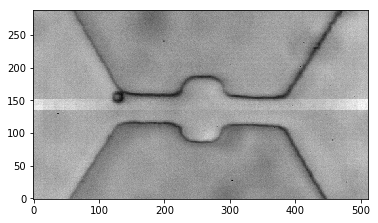

In [82]:
oi_index = 125
oi_event = oi_events[oi_index]
ts = oi_event.get_tf()
t = int((ts[-1] + ts[0])/2.)
frame = oi_vid.get_frame(t)
plt.imshow(frame, cmap = 'gray', origin = 'lower')
plt.show()

##### Video

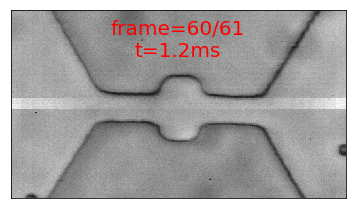

In [10]:
oi_index = 67
oi_event = oi_events[oi_index]
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_event._detections[0]._tf, oi_event._detections[-1]._tf, oi_fps).to_html5_video())

##### Append to event indices

In [91]:
count = 0    # Count the total index
split_indices = []    # Indices at which a new event transition occurs
event_indices = [68,70,81,115,121]    # Indices of events we would like to plot





# RP data
rp_indices = []
currents = []
colors = []

# OI data
tfs = []
xs = []
ys = []
pixelss = []


for i, event_index in enumerate(event_indices):
    print 'event', i
    
    split_indices.append(count)
    
    rp_event = rp_events[event_index]
    oi_event = oi_events[event_index]
    
    
    # Get sync time
    rp_sync_time = rp_get_sync_time_undulating(oi_event, oi_vid, oi_stage, rp_event, sigma = 10, debug = False)
    oi_sync_time = oi_get_sync_time(oi_event, oi_stage, oi_vid)
    
    for j, detection in enumerate(oi_event._detections):
        count += 1
        # Get time and frame index
        tf = detection._tf
        frame = oi_vid.get_frame(tf)
        
        
        # Get current value
        rp_index = int(oi_to_rp_index(rp_sync_time, oi_sync_time, tf))
        
        current = rp_data[rp_index,1]
        
        

    
        try:
            
            # Try to get ellipse
            ellipse = preprocess_fit_ellipse(frame, template_frame, detection, debug = 'none')
            
            x = ellipse[0]
            y = ellipse[1]
            
            
    
            pixels = []
            
            for k in range(int(detection._py - 20), int(detection._py + 20)):
                for l in range(int(detection._px - 20), int(detection._px + 20)):                    
                    if (k - detection._py)**2. + (l - detection._px)**2. <= ellipse[2]**2.+ellipse[3]**2.:
                        pixels.append([k,l])
        except:
            x = detection._px
            y = detection._py
            pixels = detection._pixels
            print '\tfailed on', j
            pass
        
        
        
        # Append RP information
        rp_indices.append(rp_index)
        currents.append(current)
        
        
        # Append OI information
        tfs.append(tf)
        xs.append(x)
        ys.append(y)
        
        pixelss.append(pixels)
        
for current in currents:
    colors.append(1.-(current-np.min(currents))/(np.max(currents)-np.min(currents)))
    


event 0
	failed on 0
	failed on 1
	failed on 2
	failed on 3
	failed on 4
	failed on 5
	failed on 6
	failed on 7
	failed on 8
	failed on 9
	failed on 10
	failed on 11
	failed on 12
	failed on 13
	failed on 14
	failed on 15
	failed on 16
	failed on 17
	failed on 18
	failed on 95
	failed on 96
	failed on 97
	failed on 98
	failed on 99
	failed on 100
	failed on 101
	failed on 102
	failed on 103
	failed on 104
	failed on 105
	failed on 106
	failed on 107
event 1
	failed on 0
	failed on 1
	failed on 2
	failed on 3
	failed on 4
	failed on 5
	failed on 6
	failed on 7
	failed on 8
	failed on 9
	failed on 10
	failed on 11
	failed on 12
	failed on 13
	failed on 14
	failed on 15
	failed on 16
	failed on 17
	failed on 18
	failed on 19
	failed on 20
	failed on 21
	failed on 22
	failed on 23
	failed on 24
	failed on 25
event 2
	failed on 0
	failed on 1
	failed on 2
	failed on 3
	failed on 4
	failed on 5
	failed on 6
	failed on 7
	failed on 8
	failed on 9
event 3
	failed on 0
	failed on 1
	failed on 2

In [92]:
smoothed_currents = scipy.ndimage.filters.gaussian_filter(currents, sigma = 1.25)

event  0
event  0
event  1
event  2
event  3
event  4


event  0


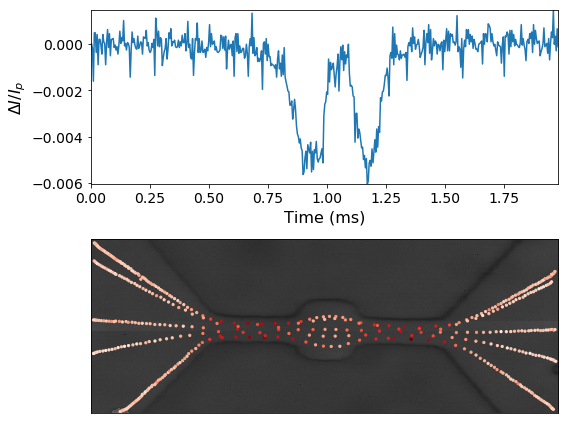

In [93]:
cmap = plt.get_cmap('Reds')
trail = 2

def animate(index):
    
    
    # Check which event we refer to
    for i in range(len(split_indices)):
        if index >= split_indices[i]:
            event_indices_index = i
            
        
    
    # Get RP related data
    rp_event = rp_events[event_indices[event_indices_index]]
    rp_index = rp_indices[index]
    
    rp_initial_time = rp_data[0,0]
    rp_time = rp_data[rp_index,0]
    current = currents[index]
    smoothed_current = smoothed_currents[index]
    
    
    # Instantaneous current plot
    dI_I = (smoothed_current - rp_event._baseline[1])/smoothed_current
    instantaneous_current_plot.set_offsets(np.array([[(rp_time-(rp_event._data[0,0]-175/250000.))*1000.], [dI_I]]))
    
    # Current plot
    for i in range(len(split_indices)):
        if index == split_indices[i]:
            print 'event ', i

            
            i0 = int(rp_event._data[0,0]*250000.)
            i1 = int(rp_event._data[-1,0]*250000.)
            
            data = np.copy(rp_data[i0-175:i1+175,:])
            
            for j in range(data.shape[0]):
                data[j,1] = (data[j,1] - rp_event._baseline[1])/data[j,1]
            
            #smoothed_data = np.hstack((data[:,0].reshape(-1,1), scipy.ndimage.gaussian_filter(data[:,1], sigma = 1.5).reshape(-1,1)))
            current_plot.set_data((data[:,0]-data[0,0])*1000., data[:,1])
            #smoothed_current_plot.set_data(smoothed_data[:,0], smoothed_data[:,1])
            
            
        
            
            
            axes[0].set_xlim((data[0,0]-data[0,0])*1000., (data[-1,0]-data[0,0])*1000.)
            axes[0].set_ylim(np.min(data[:,1]), np.max(data[:,1]))
            
    
    
    
    
    # Get OI related data
    oi_event = oi_events[event_indices[event_indices_index]]
    frame = oi_vid.get_frame(tfs[index])
    

    pixels = pixelss[index]
    
    # Create rgb frame
    rgb_frame = np.empty((frame.shape[0], frame.shape[1], 3))
    rgb_frame[:,:,0] = frame[:,:]
    rgb_frame[:,:,1] = frame[:,:]
    rgb_frame[:,:,2] = frame[:,:]
    
    for pixel in pixels:
        try:
            rgb_frame[pixel[0], pixel[1], 0] *= 2
            rgb_frame[pixel[0], pixel[1], 1] *= 2
            rgb_frame[pixel[0], pixel[1], 2] *= 2
        except:
            pass
    
    vid_plot.set_data(rgb_frame)
    
    

    if index + 1 - trail >= 0:
        position_current_plot.set_offsets(np.hstack((np.array(xs[:index+1 - trail]).reshape(-1,1), np.array(ys[:index+1 - trail]).reshape(-1,1))))
        position_current_plot.set_facecolors(cmap(colors[:index+1-trail]))

    
    axes[1].set_xlim(0, frame.shape[1])
    axes[1].set_ylim(0, frame.shape[0])
    
    
# Set up figure
fig, axes = plt.subplots(2, 1, figsize = (8,6))

# Set up top plot
plt.sca(axes[0])

current_plot, = axes[0].plot([],[])

instantaneous_current_plot = axes[0].scatter([],[], animated = True, marker = 'x', color = 'red', lw = 3, zorder = 3, s = 75)

plt.xlabel('Time (ms)', size = 16)
plt.ylabel(r'$\Delta I/I_{p}$', size = 16)
plt.tick_params(labelsize = 14)
plt.yticks([0,-0.002,-0.004,-0.006])

# Set up bottom plot

plt.sca(axes[1])

position_current_plot = axes[1].scatter([], [], animated = True, s = 5)
vid_plot = axes[1].imshow(template_frame, origin = 'lower', interpolation = 'none', aspect = 'auto')


axes[1].set_xticks([])
axes[1].set_yticks([])

fig.tight_layout()

    
anim = matplotlib.animation.FuncAnimation(fig, animate, range(len(colors)), interval = 150, blit = False)

# Convert to HTML
HTML(anim.to_html5_video())